**Table of contents**<a id='toc0_'></a>    
- 1. [Data preparation](#toc1_)    
  - 1.1. [Tokenize sentence and aspect BIO encoding class](#toc1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os 
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [2]:
import re
import pandas as pd

import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from highlight_text import HighlightText, ax_text, fig_text

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report


import nltk
from nltk.tokenize import TreebankWordTokenizer

# from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split

# 1. <a id='toc1_'></a>[Data preparation](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Tokenize sentence and aspect BIO encoding class](#toc0_)

In [3]:
class SentenceToken:
  '''
    SentenceToken

  '''
  def __init__(self, sentence, aspect_type=None, aspects=None, sentence_id=None):
    
    if sentence_id is not None:
      print(sentence_id)

    self.sentence_id = sentence_id
    self.sentence = sentence.replace(u"\u00A0", " ").replace(u'\xa0',' ') # Double check '\xa0'
                            
    self.aspect_bio_tags = None
    self.unified_aspect_bio_tags = None
    self.token_span = None
    self.space_pre_token = None

    # Tokenize sentence
    self.__tokenize_sentence(self.sentence)

    if aspect_type == 'dict':
      self.set_aspect_tagging_from_dict(aspects)
    elif aspect_type == 'bio':
      self.set_aspect_bio_tags(aspects)
    elif aspect_type == 'unified bio':
      self.set_aspect_unified_bio_tags(aspects)
  
  def __tokenize_sentence(self, sentence):
    # self.sentence = sentence
    
    token_span = list(TreebankWordTokenizer().span_tokenize(sentence))

    new_token_span = []
    
    for k in token_span:
      token_start = k[0]
      token_end = k[1]

      token = sentence[token_start:token_end]
      sub_tokens = re.split(r'([^\w,\d])', token)
      
      sub_token_start = token_start
      for sub_token in sub_tokens:
        if len(sub_token) != 0:
          sub_token_end = sub_token_start + len(sub_token)
          new_token_span.append((sub_token_start, sub_token_end))
          sub_token_start = sub_token_end
    
    self.token_span = new_token_span
    self.space_pre_token = [True if sentence[k[0]-1:k[0]] == ' ' else False for i,k in enumerate(new_token_span)]


  def set_aspect_tagging_from_dict(self, aspects):
    polarity_map = {'positive':'POS'
              ,'negative': 'NEG'
              ,'conflict': 'NEG' # Switch to Negative
              ,'neutral': 'NEU'}
    
    bio_tags = ['O'] * len(self.token_span)
    unified_bio_tags = bio_tags

    for x in aspects:
      if x['term'] != '':
        # print(x['term'], int(x['from']), int(x['to']))
        aspect_from = int(x['from'])
        aspect_to = int(x['to'])
        polarity = '-' + polarity_map[x['polarity']]
        aspect_token_ids =  [i for i, v in enumerate(self.token_span) if (v[0] >= aspect_from) & (v[1] <= aspect_to)]
        aspect_from_index = min(aspect_token_ids)
        aspect_to_index = max(aspect_token_ids)
        aspect_from = int(x['from'])
        aspect_length = aspect_to_index - aspect_from_index
        bio_tags = bio_tags[:aspect_from_index] + ['B'] + ['I'] * (aspect_length) + bio_tags[aspect_to_index+1:]
        unified_bio_tags = unified_bio_tags[:aspect_from_index] + ['B' + polarity] + ['I'+ polarity] * (aspect_length) + unified_bio_tags[aspect_to_index+1:]
    
    self.set_aspect_bio_tags(bio_tags)
    self.set_aspect_unified_bio_tags(unified_bio_tags)

  def rebuild_sentence_from_token(self):
    return ''.join([(' ' if self.space_pre_token[i] else '') + self.sentence[k[0]:k[1]] for i, k in enumerate(self.token_span)])
  
  def get_sentence_token_with_aspect_bio_tag(self, unified_bio_tag=False):
    if (unified_bio_tag == False) & (self.aspect_bio_tags is None):
      raise Exception('No BIO tags provided. Use "SentenceToken.set_aspect_bio_tags()" method to add bio_tags')
    elif (unified_bio_tag == True) & (self.aspect_unified_bio_tags is None):
      raise Exception('No Unified BIO tags provided. Use "SentenceToken.set_aspect_unified_bio_tags()" method to add unified_bio_tags')
    else:
      return [(self.sentence[k[0]:k[1]], self.aspect_unified_bio_tags[i] if unified_bio_tag else self.aspect_bio_tags[i]) for i, k in enumerate(self.token_span)]

  def set_aspect_bio_tags(self, aspect_bio_tags):
    self.aspect_bio_tags = aspect_bio_tags
    self.aspect_unified_bio_tags = aspect_bio_tags

  def set_aspect_unified_bio_tags(self, aspect_unified_bio_tags):
    self.aspect_unified_bio_tags = aspect_unified_bio_tags
    self.aspect_bio_tags = [k[0:1] for k in aspect_unified_bio_tags]

  def check_rebuild_sentence_from_token(self):
    return re.sub(r'\s+', ' ',self.sentence.strip()) == self.rebuild_sentence_from_token().strip()
  
  def get_tokens(self):
    return [self.sentence[k[0]:k[1]] for k in self.token_span]

  def check_rebuild_aspect_terms(self, aspect_dict):
    # print(self.token_span)
    aspect_dict = sorted(aspect_dict, key=lambda d: int(d['from']))
    # aspect_input = ', '.join([k['term'] for k in aspect_dict])
    # aspect_computed = ''.join([(',' if k == 'B' else '') + (' ' if self.space_pre_token[i] else '') + self.sentence[self.token_span[i][0]:self.token_span[i][1]] for i,k in enumerate(self.aspect_bio_tags) if k in ['B','I'] ])[2:]
    aspect_input = [k['term'].replace(u"\u00A0", " ").replace(u'\xa0',' ') for k in aspect_dict if k['term'] != '' ]
    aspect_computed = []
    aspect = ''
    
    for i,k in enumerate(self.aspect_bio_tags):
      # print(i, len(self.aspect_bio_tags), i == (len(self.aspect_bio_tags) - 1))
      token = self.sentence[self.token_span[i][0]:self.token_span[i][1]]
      # print(token, k)
      
      if k == 'B':
        if (self.aspect_bio_tags[i-1] == 'B' if i > 0 else False):
          aspect_computed.append(aspect)
        aspect = token
      elif k == 'I':
        aspect += ' ' * ((self.token_span[i][0] -  self.token_span[i-1][1]) if i > 0 else 0) + token
        # print(aspect)
      
      # print('Curr ', token, ' is aspect ', aspect)
      if (aspect != '') & ((k == 'O') or (i == (len(self.aspect_bio_tags) - 1))):
          aspect_computed.append(aspect)
          aspect = ''
      
      # print(((self.aspect_bio_tags[i-1] == 'B') & (k == 'B')))
      # print(aspect_computed)
    # if aspect != '':
    #   aspect_computed.append(aspect)
    # aspect_computed = [(',' if k == 'B' else '') + (' ' if self.space_pre_token[i] else '') + self.sentence[self.token_span[i][0]:self.token_span[i][1]] for i,k in enumerate(self.aspect_bio_tags) if k in ['B','I'] ])[2:]
    # print(aspect_computed)
    return [aspect_input == aspect_computed, aspect_input, aspect_computed]

  def __str__(self):
    return self.rebuild_sentence_from_token()


In [4]:
# df_train = pd.read_json('data/laptop/train.json')
# # df_train.set_index('id', inplace=True).reset_index()
# print('df_train shape: ', df_train.shape)

# df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
# # df_val.set_index('id', inplace=True).reset_index()
# print('df_val shape: ', df_val.shape)

# # First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
# df_train.drop_duplicates(subset='text', inplace=True)

# # We have removed 12 duplicated records in our training dataset
# print(df_train.shape)

In [5]:
def reload_Data():
  df_train = pd.read_json('data/laptop/train.json')
  # First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
  # We have removed 12 duplicated records in our training dataset
  df_train.drop_duplicates(subset='text', inplace=True)
  print('df_train shape: ', df_train.shape)

  df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
  # df_val.set_index('id', inplace=True).reset_index()
  print('df_val shape: ', df_val.shape)

  df_train['sentence_token'] = df_train.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
  df_train['sentence_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
  df_train['aspect_check'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)
  df_train['aspect_check_TF'] = df_train.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects'])[0], axis=1)
  df_train['tokens'] = df_train.apply(lambda x: x['sentence_token'].get_tokens(), axis=1)
  df_train['tags'] = df_train.apply(lambda x: x['sentence_token'].aspect_unified_bio_tags, axis=1)

  df_val['sentence_token'] = df_val.apply(lambda x: SentenceToken(x['text'], 'dict', x['aspects']), axis=1)
  df_val['sentence_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_sentence_from_token(), axis=1)
  df_val['aspect_check'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects']), axis=1)
  df_val['aspect_check_TF'] = df_val.apply(lambda x: x['sentence_token'].check_rebuild_aspect_terms(x['aspects'])[0], axis=1)
  df_val['tokens'] = df_val.apply(lambda x: x['sentence_token'].get_tokens(), axis=1)
  df_val['tags'] = df_val.apply(lambda x: x['sentence_token'].aspect_unified_bio_tags, axis=1)
  return df_train, df_val

In [6]:
df_train, df_test = reload_Data()
print('# of df_train records having tokenizing issues: ', len(df_train[df_train['sentence_check']==False]))
# print('# of df_train records having aspect bio tagging issues: ', len(df_train[df_train['aspect_check'].apply(lambda x: x[0]==False)]))
print('# of df_train records having aspect bio tagging issues: ', len(df_train[df_train['aspect_check_TF']==False]))
print('# of df_test records having tokenizing issues: ', len(df_test[df_test['sentence_check']==False]))
# print('# of df_val records having  aspect bio tagging issues: ', len(df_val[df_val['aspect_check'].apply(lambda x: x[0]==False)]))
print('# of df_test records having aspect bio tagging issues: ', len(df_test[df_test['aspect_check_TF']==False]))

df_train shape:  (3036, 3)
df_val shape:  (800, 3)
# of df_train records having tokenizing issues:  0
# of df_train records having aspect bio tagging issues:  0
# of df_test records having tokenizing issues:  0
# of df_test records having aspect bio tagging issues:  1


# Pytorch 

In [8]:
import datasets
from datasets import Dataset, DatasetDict

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

tds = Dataset.from_pandas(df_train[['tokens','tags']])
vds = Dataset.from_pandas(df_val[['tokens','tags']])
tsds = Dataset.from_pandas(df_test[['tokens','tags']])


ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds
ds['test'] = tsds

print(ds)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags', '__index_level_0__'],
        num_rows: 2428
    })
    validation: Dataset({
        features: ['tokens', 'tags', '__index_level_0__'],
        num_rows: 608
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 800
    })
})


In [9]:
# from datasets import get_dataset_config_names

# xtreme_subsets = get_dataset_config_names("xtreme")
# print(f"XTREME has {len(xtreme_subsets)} configurations")

In [10]:
# panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
# panx_subsets[:3]

In [11]:
# from datasets import load_dataset

# load_dataset("xtreme", name='PAN-X.de')

In [12]:
# # hide_output
# from collections import defaultdict
# from datasets import DatasetDict

# langs = ["de", "fr", "it", "en"]
# fracs = [0.629, 0.229, 0.084, 0.059]
# # Return a DatasetDict if a key doesn't exist
# panx_ch = defaultdict(DatasetDict)

# for lang, frac in zip(langs, fracs):
#     # Load monolingual corpus
#     ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
#     # Shuffle and downsample each split according to spoken proportion
#     for split in ds:
#         panx_ch[lang][split] = (
#             ds[split]
#             .shuffle(seed=0)
#             .select(range(int(frac * ds[split].num_rows))))
     

In [13]:
# import pandas as pd

# pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
#              index=["Number of training examples"])

In [14]:
# element = panx_ch["de"]["train"][0]
# for key, value in element.items():
#     print(f"{key}: {value}")

In [15]:
# for key, value in panx_ch["de"]["train"].features.items():
#     print(f"{key}: {value}")

In [16]:
# tags = panx_ch["de"]["train"].features["ner_tags"].feature
# print(tags)

In [17]:
tags = set(sum(ds['train']['tags'],[]))
# int2str
tags

{'B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O'}

In [18]:
# # hide_output
# def create_tag_names(batch):
#     return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

# panx_de = panx_ch["de"].map(create_tag_names)

In [19]:
# # hide_output
# de_example = panx_de["train"][0]
# pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
# ['Tokens', 'Tags'])

In [20]:
# df_example = df_train.iloc[0]
# pd.DataFrame([df_example["tokens"], df_example["tags"]],
# ['Tokens', 'Tags'])

In [21]:
# from collections import Counter

# split2freqs = defaultdict(Counter)
# for split, dataset in panx_de.items():
#     for row in dataset["ner_tags_str"]:
#         for tag in row:
#             if tag.startswith("B"):
#                 tag_type = tag.split("-")[1]
#                 split2freqs[split][tag_type] += 1
# pd.DataFrame.from_dict(split2freqs, orient="index")

In [22]:
from collections import Counter

pd.DataFrame([Counter([tag.split("-")[1] for tag in sum(ds['train']['tags'],[]) if tag.startswith("B")])
              ,Counter([tag.split("-")[1] for tag in sum(ds['validation']['tags'],[]) if tag.startswith("B")])
              ,Counter([tag.split("-")[1] for tag in sum(ds['test']['tags'],[]) if tag.startswith("B")])]
              ,['Train','Validation','Test'])

,POS,NEG,NEU
Train,789,687,348
Validation,199,224,115
Test,341,144,169


# Multilingual Transformers

## A Closer Look at Tokenization

In [23]:
# hide_output
from transformers import AutoTokenizer

# bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
# bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [24]:
# text = ds['train'][0]['tokens']
# bert_tokens = bert_tokenizer(text, is_split_into_words=True).tokens()
# xlmr_tokens = xlmr_tokenizer(text, is_split_into_words=True).tokens()

In [25]:
# #hide_input
# df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
# df

## The SentencePiece Tokenizer

In [26]:
# "".join(xlmr_tokens).replace(u"\u2581", " ")

## Creating a Custom Model for Token Classification

In [27]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForABSA(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)
     

/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/tina.vu/work/fun/sentilens_env_wipp/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Loading a Custom Model
https://github.com/nlp-with-transformers/notebooks/blob/main/04_multilingual-ner.ipynb

In [28]:
tags = set(sum(ds['train']['tags'],[]))
tags

{'B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O'}

In [29]:
index2tag = {idx: tag for idx, tag in enumerate(tags)}
tag2index = {tag: idx for idx, tag in enumerate(tags)}
tag2index

{'B-POS': 0,
 'B-NEU': 1,
 'B-NEG': 2,
 'I-NEG': 3,
 'I-POS': 4,
 'I-NEU': 5,
 'O': 6}

In [30]:
# hide_output
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=len(index2tag), #tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [31]:
# hide_output
import torch

device = evice = torch.device('mps') # The current use is for Mac, the following here maybe needed for windows torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForABSA
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of XLMRobertaForABSA were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# hide_output
# input_ids = xlmr_tokenizer.encode(text, is_split_into_words=True, return_tensors="pt")
# input_ids

In [33]:
# pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"]).T

In [34]:

# outputs = xlmr_model(input_ids.to(device)).logits
# predictions = torch.argmax(outputs, dim=-1)
# print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
# print(f"Shape of outputs: {outputs.shape}")

In [35]:
# preds = [index2tag[p] for p in predictions[0].cpu().numpy()]
# pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"]).T

In [36]:
# def tag_text(tokens, index2tag, model
#              , tokenizer
#              ):
#     # Get tokens with special characters
#     # tokens = tokenizer(text).tokens()
#     # Encode the sequence into IDs
#     input_ids = tokenizer(tokens, is_split_into_words=True, return_tensors="pt").input_ids.to(device)
#     # Get predictions as distribution over 7 possible classes
#     outputs = model(input_ids)[0]
#     # Take argmax to get most likely class per token
#     predictions = torch.argmax(outputs, dim=2)
#     # Convert to DataFrame
#     preds = [index2tag[p] for p in predictions[0].cpu().numpy()]
#     return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

## Tokenizing Texts for NER

In [37]:
# words, tags = df_example["tokens"], df_example["tags"]

In [38]:
# tokenized_input = xlmr_tokenizer(df_example["tokens"], is_split_into_words=True)
# tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [39]:
#hide_output
# pd.DataFrame([tokens, tags], index=["Tokens", 'labels']).T

In [40]:
# hide_output
# word_ids = tokenized_input.word_ids()
# pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"]).T

In [41]:
# #hide_output
# previous_word_idx = None
# labels = []

# for word_idx in word_ids:       
#     if word_idx is None or word_idx == previous_word_idx:
#         labels.append('IGN')
#     elif word_idx != previous_word_idx:
#         labels.append(tags[word_idx])
#     previous_word_idx = word_idx
    
# label_ids = [tag2index[l] if l != 'IGN' else -100 for l in labels]

# index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

# pd.DataFrame([tokens, word_ids, label_ids, labels], index=index).T

In [42]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(tag2index[label[word_idx]])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [43]:
def encode_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['tags', 'tokens']
                      )

In [44]:
# hide_output
ds_encoded = encode_dataset(ds)

Map:   0%|          | 0/2428 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

# Performance Measures

In [45]:
from seqeval.metrics import classification_report

# y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
#           ["B-PER", "I-PER", "O"]]
# y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
#           ["B-PER", "I-PER", "O"]]
# print(classification_report(y_true, y_pred))

In [46]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list
     

# Fine-Tuning XLM-RoBERTa

In [47]:
# hide_output
from transformers import TrainingArguments

num_epochs = 6
batch_size = 24
logging_steps = len(ds["train"]) // batch_size
model_name = f"{xlmr_model_name}-absa"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

In [48]:

#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [49]:

from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred), "f1_macro": f1_score(y_true, y_pred, average='macro')}
     

In [50]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

2024-01-23 11:53:52.818357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
def model_init():
    return (XLMRobertaForABSA
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))
     

In [52]:
# hide_output
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)
     


In [53]:
# pip install torch==2.2.0 torchtext --index-url https://download.pytorch.org/whl/test/cpu

In [54]:

#hide_input
trainer.train()


  0%|          | 0/612 [00:00<?, ?it/s]

{'loss': 0.271, 'learning_rate': 4.17483660130719e-05, 'epoch': 0.99}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.18413874506950378, 'eval_f1': 0.39865433137089995, 'eval_f1_macro': 0.30503972950546276, 'eval_runtime': 10.07, 'eval_samples_per_second': 60.377, 'eval_steps_per_second': 2.582, 'epoch': 1.0}
{'loss': 0.1143, 'learning_rate': 3.349673202614379e-05, 'epoch': 1.98}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.1321128010749817, 'eval_f1': 0.5432999088422972, 'eval_f1_macro': 0.4849103653393267, 'eval_runtime': 7.3116, 'eval_samples_per_second': 83.156, 'eval_steps_per_second': 3.556, 'epoch': 2.0}
{'loss': 0.0704, 'learning_rate': 2.5245098039215685e-05, 'epoch': 2.97}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.14638599753379822, 'eval_f1': 0.5682242990654205, 'eval_f1_macro': 0.5350069148281666, 'eval_runtime': 5.5906, 'eval_samples_per_second': 108.755, 'eval_steps_per_second': 4.651, 'epoch': 3.0}
{'loss': 0.0473, 'learning_rate': 1.6993464052287582e-05, 'epoch': 3.96}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.14634408056735992, 'eval_f1': 0.6021314387211367, 'eval_f1_macro': 0.5771830789949196, 'eval_runtime': 6.057, 'eval_samples_per_second': 100.381, 'eval_steps_per_second': 4.293, 'epoch': 4.0}
{'loss': 0.0307, 'learning_rate': 8.741830065359477e-06, 'epoch': 4.95}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.15711809694766998, 'eval_f1': 0.6277630415561449, 'eval_f1_macro': 0.6002964881651965, 'eval_runtime': 6.5738, 'eval_samples_per_second': 92.489, 'eval_steps_per_second': 3.955, 'epoch': 5.0}
{'loss': 0.0192, 'learning_rate': 4.901960784313725e-07, 'epoch': 5.94}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 0.1652992218732834, 'eval_f1': 0.6383731211317417, 'eval_f1_macro': 0.6187384358380648, 'eval_runtime': 7.2266, 'eval_samples_per_second': 84.134, 'eval_steps_per_second': 3.598, 'epoch': 6.0}
{'train_runtime': 3051.2435, 'train_samples_per_second': 4.774, 'train_steps_per_second': 0.201, 'train_loss': 0.09143147991324951, 'epoch': 6.0}


TrainOutput(global_step=612, training_loss=0.09143147991324951, metrics={'train_runtime': 3051.2435, 'train_samples_per_second': 4.774, 'train_steps_per_second': 0.201, 'train_loss': 0.09143147991324951, 'epoch': 6.0})

In [70]:
trainer.push_to_hub(commit_message="Training completed!")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

events.out.tfevents.1706028839.PRODIGYMAC-C02D64MJMD6R.15056.0:   0%|          | 0.00/8.19k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/tnatvu/xlm-roberta-base-absa/commit/287181a14c225d7508e274c215c266865d0fe071', commit_message='Training completed!', commit_description='', oid='287181a14c225d7508e274c215c266865d0fe071', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
# https://huggingface.co/tnatvu/xlm-roberta-base-finetuned-panx-de/commit/392fb1439a34c700ee40c2b53da7b342f86aea5e
# CommitInfo(commit_url='https://huggingface.co/tnatvu/xlm-roberta-base-absa/commit/287181a14c225d7508e274c215c266865d0fe071', commit_message='Training completed!', commit_description='', oid='287181a14c225d7508e274c215c266865d0fe071', pr_url=None, pr_revision=None, pr_num=None)
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1','eval_f1_macro']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1",'eval_f1_macro':'Macro F1'})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1,Macro F1
0,1,0.2710,0.184139,0.398654,NaN
1,1,0.2710,0.184139,0.398654,0.305040
2,2,0.1143,0.132113,0.543300,NaN
3,2,0.1143,0.132113,0.543300,0.484910
4,3,0.0704,0.146386,0.568224,NaN
5,3,0.0704,0.146386,0.568224,0.535007
6,4,0.0473,0.146344,0.602131,NaN
7,4,0.0473,0.146344,0.602131,0.577183
8,5,0.0307,0.157118,0.627763,NaN
9,5,0.0307,0.157118,0.627763,0.600296


In [57]:
# pip install torch==2.3.0.dev20240121 # this does not work

# pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu # run this in CLI before running the notebook

# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")

# Error analysis

In [58]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}
     

In [59]:
tag2index

{'B-POS': 0,
 'B-NEU': 1,
 'B-NEG': 2,
 'I-NEG': 3,
 'I-POS': 4,
 'I-NEU': 5,
 'O': 6}

# Model performance

In [143]:
# hide_output
valid_set = ds_encoded["test"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df_test = valid_set.to_pandas()

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [180]:
index2tag[-100] = "IGN"

df_test["predicted_label"] = df_test["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df_test["labels"] = df_test["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df_test['loss'] = df_test.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df_test['predicted_label'] = df_test.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

# hide_output
df_tokens = df_test.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
# df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
# df_tokens.head(7)

In [192]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(df_tokens['labels'], df_tokens['predicted_label'], average='macro')
print(macro_f1)


0.69145189490994


# Check for model errors

In [111]:
# hide_output
valid_set = ds_encoded["test"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [112]:
index2tag[-100] = "IGN"

df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label
0,58800,1,B-POS,0.01,B-POS
0,1733,1,I-POS,0.02,I-POS
0,83,1,O,0.00,O
0,1601,1,O,0.00,O
0,4271,1,O,0.00,O
0,6,1,O,0.00,O
0,10932,1,O,0.00,O


In [63]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,58800,1,B-POS,0.01,B-POS,▁Boot
0,1733,1,I-POS,0.02,I-POS,▁time
0,83,1,O,0.00,O,▁is
0,1601,1,O,0.00,O,▁super
0,4271,1,O,0.00,O,▁fast
0,6,1,O,0.00,O,▁
0,10932,1,O,0.00,O,▁around


Group by word token

In [64]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁the,"▁""",▁price,▁i,▁(,▁),▁OS,▁install,▁drive
count,1188,405,34,25,43,29,31,27,9,14
mean,0.07,0.17,1.54,1.36,0.62,0.89,0.82,0.83,2.29,1.4
sum,83.23,68.67,52.35,34.03,26.85,25.74,25.36,22.41,20.59,19.59


Group by label ID

In [65]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-NEU,I-POS,B-NEU,I-NEG,B-NEG,B-POS,O
count,203,170,169,97,144,341,11122
mean,2.24,2.16,1.96,1.8,1.12,0.98,0.01
sum,455.2,366.93,331.28,174.45,161.58,335.71,157.71


In [66]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

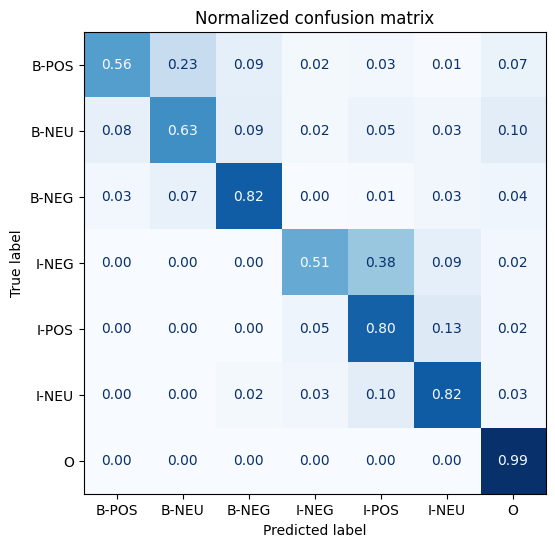

In [67]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      list(tag2index.keys()))


In [68]:
# hide_output
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample.T)
     

,tokens,labels,preds,losses
0,▁This,O,O,0.00
1,▁version,O,O,0.00
2,▁of,O,O,0.00
3,▁MacBook,O,O,0.00
4,▁Pro,O,O,0.00
5,▁runs,O,O,0.00
6,▁on,O,O,0.00
7,▁a,O,O,0.00
8,▁third,B-NEU,O,2.51
9,▁-,I-NEU,I-NEU,0.13


,tokens,labels,preds,losses
0,▁The,O,O,0.00
1,▁Like,O,O,0.00
2,▁New,O,O,0.00
3,▁condition,O,O,0.00
4,▁of,O,O,0.00
...,...,...,...,...
90,▁nice,O,O,0.00
91,▁package,B-POS,O,1.88
92,▁,O,O,0.00
93,.,IGN,O,-0.00


,tokens,labels,preds,losses
0,▁also,O,O,0.00
1,▁,O,O,0.00
2,.,IGN,O,-0.00
3,▁,O,O,0.00
4,.,IGN,O,-0.00
5,▁,O,O,0.00
6,.,IGN,O,-0.00
7,▁-,O,O,0.00
8,▁excellent,O,O,0.00
9,▁operating,B-POS,B-POS,0.01


Errors could be from human / annotation errors: United Nations is ORG, not PER, similar to Central African Republic. This can happen as data was annotated using rule based, it is better with human annotations, but mistakes can always occur.

In [69]:

# hide_output
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample.T)

,tokens,labels,preds,losses
0,▁Other,O,O,0.00
1,▁than,O,O,0.00
2,▁not,O,O,0.00
3,▁being,O,O,0.00
4,▁a,O,O,0.00
5,▁fan,O,O,0.00
6,▁of,O,O,0.00
7,▁click,B-NEG,B-NEG,0.01
8,▁pad,I-NEG,I-NEG,0.01
9,s,IGN,I-NEG,-0.00


,tokens,labels,preds,losses
0,▁No,O,O,0.00
1,▁installation,B-NEU,B-NEG,3.71
2,▁disk,I-NEU,I-NEG,3.00
3,▁(,I-NEU,O,8.43
4,▁DVD,I-NEU,B-NEG,6.25
5,▁),I-NEU,O,9.25
6,▁is,O,O,0.00
7,▁included,O,O,0.00
8,▁,O,O,0.00
9,.,IGN,O,-0.00


# Load saved model

In [ ]:
xlmr_tokenizer.save_pretrained('xlmr_tokenizer')

In [198]:
from transformers import AutoModelForSequenceClassification

# Reload the model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_name) #output_model_dir
loaded_tokenizer = AutoTokenizer.from_pretrained('xlmr_tokenizer')

In [207]:
# Assuming you have some input data
input_data = "Your input data here"
# Tokenize and get predictions
inputs = loaded_tokenizer(input_data, is_split_into_words=False, return_tensors="pt")
print(inputs)
outputs = loaded_model(**inputs)
# predictions = outputs.logits  # Adjust this based on the model's output

predicted_label = torch.argmax(outputs.logits, axis=-1).cpu().numpy()

# Use predictions as needed
predicted_label


{'input_ids': tensor([[     0,  14804, 107730,   2053,   3688,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 7)

In [203]:
# # hide_output
# valid_set = ds_encoded["test"]
# valid_set = valid_set.map(forward_pass_with_label_from_saved, batched=True, batch_size=32)
# df_test = valid_set.to_pandas()

In [ ]:
index2tag[-100] = "IGN"

df_test["predicted_label"] = df_test["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df_test["labels"] = df_test["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df_test['loss'] = df_test.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df_test['predicted_label'] = df_test.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

# hide_output
df_tokens = df_test.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
# df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
# df_tokens.head(7)

In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(df_tokens['labels'], df_tokens['predicted_label'], average='macro')
print(macro_f1)
